In [ ]:
bucket = 'applied-data-science-uob-2018'
prefix = 'sagemaker/xgboost'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

In [4]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

In [2]:
!wget https://s3-eu-west-1.amazonaws.com/applied-data-science-uob-2018/sagemaker/xgboost/data2.csv

--2018-05-03 17:46:20--  https://s3-eu-west-1.amazonaws.com/applied-data-science-uob-2018/sagemaker/xgboost/pdata.csv
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 54.231.131.43
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|54.231.131.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159479 (156K) [text/csv]
Saving to: ‘pdata.csv’

pdata.csv           100%[===================>] 155.74K   259KB/s    in 0.6s    

2018-05-03 17:46:21 (259 KB/s) - ‘pdata.csv’ saved [159479/159479]



In [22]:
data = pd.read_csv('./data2.csv', sep=',')
data = data.iloc[:, 1:]
data = data[['window_open', 'temperature', 'humidity', 'volume']]
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 10)         # Keep the output on one page
data

,window_open,temperature,humidity,volume
0,0,0.000000,0.00,29.232
1,0,0.000000,0.00,28.224
2,0,0.000000,0.00,14.400
3,0,0.000000,0.00,30.600
4,0,0.000000,0.00,34.200
...,...,...,...,...
3348,0,-0.066667,-0.01,14.400
3349,0,-0.018333,0.00,30.600
3350,0,-0.015000,-0.02,34.200
3351,0,-0.010000,0.09,12.376


,window_open,temperature,humidity,volume
count,3353.000000,3.353000e+03,3353.000000,3353.000000
mean,0.158664,-1.778258e-03,-0.005419,26.914286
std,0.365417,2.890540e-02,0.218468,9.234991
min,0.000000,-1.150000e-01,-2.248000,12.376000
25%,0.000000,-1.000000e-02,-0.090000,14.400000
50%,0.000000,-7.105427e-15,0.000000,29.232000
75%,0.000000,5.000000e-03,0.050000,34.200000
max,1.000000,1.700000e-01,2.760000,39.368000


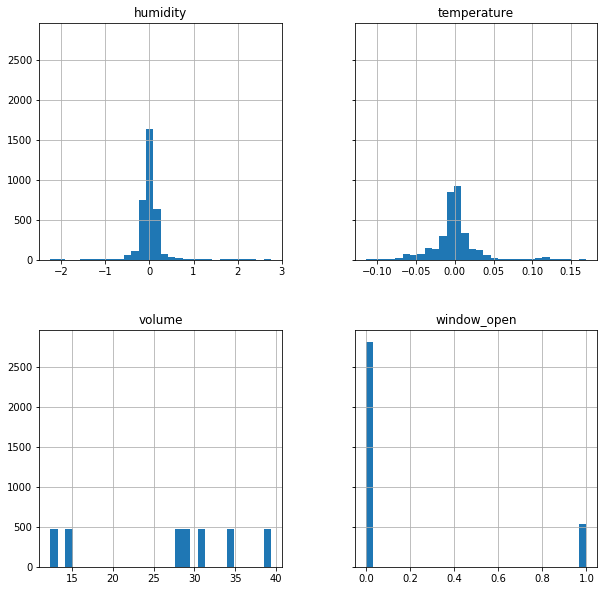

In [23]:
# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

,window_open,temperature,humidity,volume
window_open,1.000000,-0.097272,-0.095618,0.273248
temperature,-0.097272,1.000000,0.088898,-0.011263
humidity,-0.095618,0.088898,1.000000,0.002326
volume,0.273248,-0.011263,0.002326,1.000000


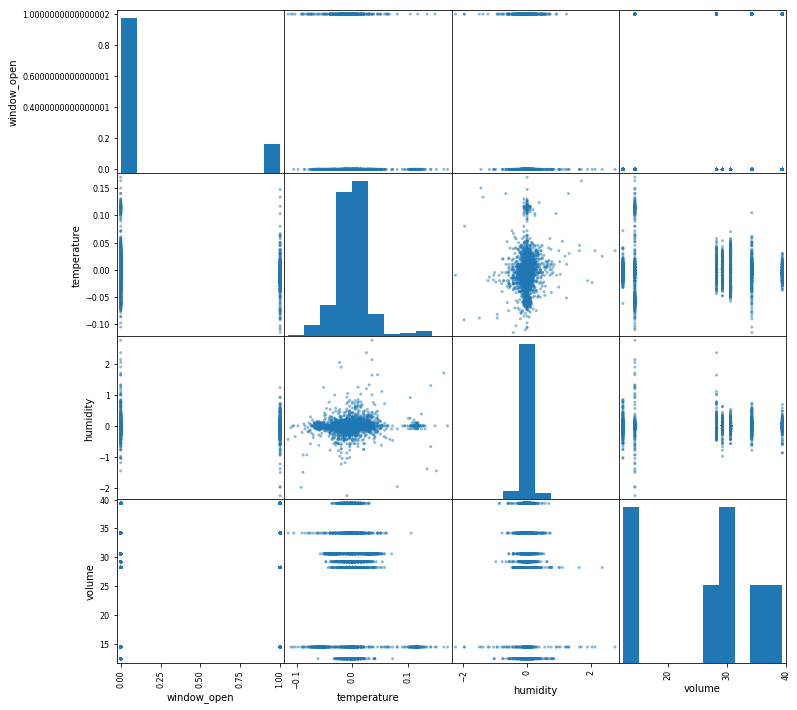

In [24]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

In [25]:
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

In [26]:
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

In [27]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [28]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [29]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [30]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-05-03-18-05-03-984


..........................................
Arguments: train
[2018-05-03:18:08:29:INFO] Running standalone xgboost training.
[2018-05-03:18:08:29:INFO] File size need to be processed in the node: 0.12mb. Available memory size in the node: 8622.34mb
/opt/amazon/lib/python2.7/site-packages/sage_xgboost/train_helper.py:322: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(files_path, csv_file), sep=None, header=None)
[18:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=5
[0]#011train-error:0.122284#011validation-error:0.116418
[18:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=5
[1]#011train-error:0.113762#011validation-error:0.10597
[18:08:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra

===== Job Complete =====
Billable seconds: 105


In [31]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-05-03-18-09-25-701
INFO:sagemaker:Creating endpoint with name xgboost-2018-05-03-18-05-03-984


---------------------------------------------------------------!

In [41]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['window_open'], axis=1).as_matrix())

pd.crosstab(index=test_data['window_open'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,266,17
1,24,29
